In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

import os
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")


In [2]:
def getAccuracy(completion_eqns, expected_completion_eqns, eval_dict):
    def LHSOfEqn(eqn_str):
        first_equals = eqn_str.find('=')
        LHS = eqn_str[0:first_equals].replace(' ', '')
        return LHS

    def RHSOfEqn(eqn_str):
        last_equals = eqn_str.rfind('=')
        RHS = eqn_str[last_equals+1:].replace(' ', '')
        return RHS

    '''
    metric = value | verbatim
    accuracyType = numCorrectOverTotal | firstIncorrectOverTotal

    ((accuracy[type])[metric]) = a number

    accuracy = {
        numCorrectAcc: {
            value: ...,
            verbatim: ...,
        },
        firstIncorrectAcc: {
            value: ...,
            verbatim: ...,
        }
    }
    '''
    numCorrectAcc = {"value": 0, "verbatim": 0}
    firstIncorrectAcc = {"value": 1, "verbatim": 1}
    _firstIncorrectValNotFound = True
    _firstIncorrectVerbNotFound = True

    num_expected_eqns = len(expected_completion_eqns)
    for i in range(num_expected_eqns):
        expected_eqn = expected_completion_eqns[i]

        try:
            completion_eqn = completion_eqns[i]
        except:
            completion_eqn = ''

        completion_LHS, completion_RHS = LHSOfEqn(
            completion_eqn), RHSOfEqn(completion_eqn)

        try:
            equal_verbatim = (completion_eqn == expected_eqn)
        except:
            equal_verbatim = False

        try:
            equal_value = (eval_dict[completion_LHS]
                           == int(completion_RHS[-2:]))
        except:
            equal_value = False

        numCorrectAcc["value"] += int(equal_value) / num_expected_eqns
        numCorrectAcc["verbatim"] += int(equal_verbatim) / num_expected_eqns

        if (not equal_value) and _firstIncorrectValNotFound:
            firstIncorrectAcc["value"] = i / num_expected_eqns
            _firstIncorrectValNotFound = False
        if (not equal_verbatim) and _firstIncorrectVerbNotFound:
            firstIncorrectAcc["verbatim"] = i / num_expected_eqns
            _firstIncorrectVerbNotFound = False

    accuracy = {
        "numCorrectAcc": numCorrectAcc,
        "firstIncorrectAcc": firstIncorrectAcc,
    }

    return accuracy


def averageOfAccuracies(accs):
    acc_avg = {
        "numCorrectAcc": {
            "value": 0,
            "verbatim": 0,
        },
        "firstIncorrectAcc": {
            "value": 0,
            'verbatim': 0,
        }
    }

    for acc in accs:
        for _type in acc.keys():
            for _metric in acc[_type].keys():
                acc_avg[_type][_metric] += acc[_type][_metric] / len(accs)

    return acc_avg


def strToEqns(text):
    _completion_lines = text.split('\n')
    _completion_lines = [eqn.replace('\n', '') for eqn in _completion_lines]
    _eqn_idxs = [i for i, completion_line in enumerate(
        _completion_lines) if '=' in completion_line]
    eqns = [_completion_lines[eqn_idx] for eqn_idx in _eqn_idxs]
    return eqns


In [3]:
experiments = []
experiments_config = []

for hint_len in range(0, 12+1, 2):
    experiments.append(pd.read_json(
        rf'data/[20]{hint_len}_hints,12_var.json', orient='records'))
    experiments_config.append(pd.read_json(
        rf'data/[config][20]{hint_len}_hints,12_var.json', orient='records'))


In [4]:
ACCS_OF_HINTLEN = {}  # HINTLEN_VS_ACC[len] = list of accuracies
EXPECTED_ACC_OF_HINTLEN = {}

num_experiments = len(experiments)
for i_expt in range(num_experiments):

    trials = experiments[i_expt]
    config = experiments_config[i_expt]

    HINTLEN = int(config.NUM_NAME_HINTS)
    ACCS_OF_HINTLEN[HINTLEN] = []
    EXPECTED_ACC_OF_HINTLEN[HINTLEN] = max(float((config.NUM_NAME_HINTS - config.NUM_EQN_HINTS) / (
        config.NUM_VARS-config.NUM_EQN_HINTS)), 0)  # acc if hint correct and rest incorrect

    num_trials = len(trials)
    for i_trial in range(num_trials):
        trial = trials.iloc[i_trial]

        completion_text = trial.completion
        expected_completion_text = trial.expected_completion
        eval_dict = trial.eval_dict

        completion_eqns = strToEqns(completion_text)
        expected_completion_eqns = strToEqns(expected_completion_text)

        ACC = getAccuracy(completion_eqns, expected_completion_eqns, eval_dict)

        ACCS_OF_HINTLEN[HINTLEN].append(ACC)


In [5]:
AVG_ACC_OF_HINTLEN = {}  # accuracy of hint length averaged over all trials

for hintlen in ACCS_OF_HINTLEN.keys():
    AVG_ACC_OF_HINTLEN[hintlen] = averageOfAccuracies(ACCS_OF_HINTLEN[hintlen])


In [6]:
EXPECTED_ACC_OF_HINTLEN
AVG_ACC_OF_HINTLEN

{0: {'numCorrectAcc': {'value': 0.3950000000000001, 'verbatim': 0.055},
  'firstIncorrectAcc': {'value': 0.12, 'verbatim': 0.03}},
 2: {'numCorrectAcc': {'value': 0.4249999999999999,
   'verbatim': 0.049999999999999996},
  'firstIncorrectAcc': {'value': 0.115, 'verbatim': 0.030000000000000002}},
 4: {'numCorrectAcc': {'value': 0.49999999999999994, 'verbatim': 0.125},
  'firstIncorrectAcc': {'value': 0.19000000000000006, 'verbatim': 0.055}},
 6: {'numCorrectAcc': {'value': 0.51, 'verbatim': 0.14500000000000002},
  'firstIncorrectAcc': {'value': 0.34500000000000003, 'verbatim': 0.08}},
 8: {'numCorrectAcc': {'value': 0.5950000000000001,
   'verbatim': 0.16500000000000004},
  'firstIncorrectAcc': {'value': 0.29500000000000004, 'verbatim': 0.065}},
 10: {'numCorrectAcc': {'value': 0.595, 'verbatim': 0.24000000000000002},
  'firstIncorrectAcc': {'value': 0.395, 'verbatim': 0.08000000000000002}},
 12: {'numCorrectAcc': {'value': 0.51, 'verbatim': 0.18000000000000002},
  'firstIncorrectAcc': 

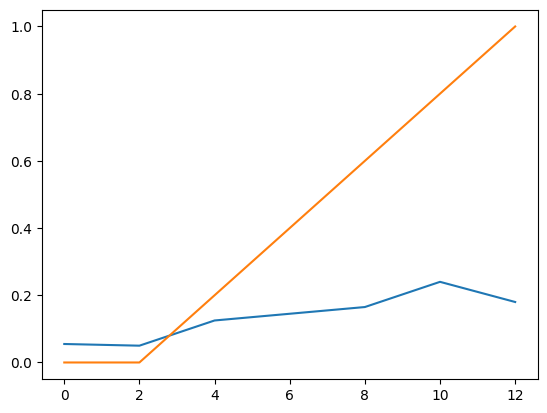

In [7]:
ACC_TYPE = 'numCorrectAcc'  # 'numCorrectAcc' | 'firstIncorrectAcc'
ACC_METRIC = 'verbatim'  # 'verbatim' | 'value'


xs = AVG_ACC_OF_HINTLEN.keys()
ys = [AVG_ACC_OF_HINTLEN[key][ACC_TYPE][ACC_METRIC] for key in AVG_ACC_OF_HINTLEN.keys()]

plt.plot(xs,ys)

ys_expected = EXPECTED_ACC_OF_HINTLEN.values()
plt.plot(xs,ys_expected)


plt.show()